In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import pandas_datareader as web
import datetime as dt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import talib
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,average_precision_score,precision_score,confusion_matrix
#from keras.models import Sequential
#from keras.layers import Dense
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [8]:
start="1-1-1900"
end=dt.datetime.today()
ticker="SPY"
data=web.DataReader(ticker,"yahoo",start,end)
inv=10000
data=data[:]
data['Pct Change']=data['Close'].pct_change()*100
data['Movement']=None
m=0.5
for i in range(len(data['Pct Change'])):
    if data['Pct Change'].iloc[i]<-m:
        data['Movement'].iloc[i]=-1
    elif data['Pct Change'].iloc[i]>m:
        data['Movement'].iloc[i]=1
    else:
        data['Movement'].iloc[i]=0
data

/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,High,Low,Open,Close,Volume,Adj Close,Pct Change,Movement
Date,,,,,,,,
1993-01-29,43.968750,43.750000,43.968750,43.937500,1003200.0,26.184059,NaN,0
1993-02-01,44.250000,43.968750,43.968750,44.250000,480500.0,26.370279,0.711238,1
1993-02-02,44.375000,44.125000,44.218750,44.343750,201300.0,26.426161,0.211864,0
1993-02-03,44.843750,44.375000,44.406250,44.812500,529400.0,26.705482,1.057082,1
1993-02-04,45.093750,44.468750,44.968750,45.000000,531500.0,26.817228,0.418410,0
...,...,...,...,...,...,...,...,...
2020-07-06,317.679993,315.559998,316.369995,317.049988,61713800.0,317.049988,1.543726,1
2020-07-07,317.519989,313.369995,315.380005,313.779999,82910000.0,313.779999,-1.031380,-1
2020-07-08,316.299988,312.700012,314.609985,316.179993,54638600.0,316.179993,0.764865,1


In [9]:
#Feature Engineering
fdata=pd.DataFrame(index=data.index)
fdata['DReturn']=(data['Close']/data['Open']).apply(np.log)
fdata['Vol']=data['Volume'].apply(np.log)
fdata['High']=data['High'].apply(np.log)
fdata['Close']=data['Close']
fdata[f'Vol Diff 16']=data['Volume'].diff(16)
fdata['Vol Diff 50'] = data['Volume'].diff(50)
fdata['pctc'] = data[['Volume']].astype(int).apply(lambda x: x.pct_change()) 
for i in range(1,10):
    fdata[f'mavg{i}']=(data['Adj Close'].rolling(i).mean()).dropna()
fdata['std']=data['Adj Close'].rolling(30).mean().dropna()
#fdata['mr']=data['Adj Close']/data['Adj Close'].shift(1)
period=np.arange(1,31)
#for i in range(1,10):
    #name = 'LaggedReturn_' + str(i)
    #fdata[name] = data['Close'].pct_change(periods=i)
for i in range(1, len(period)):
    fdata['SMA-%i'%period[i]] = talib.MA(data['Close'], timeperiod=period[i])
for i in range(1, len(period)):
    fdata['EMA-%i'%period[i]] = talib.EMA(data['Close'], timeperiod=period[i])
#fdata['OBV']=talib.OBV(data['Close'], data['Volume'])
#fdata['HT_TRENDLINE']=talib.HT_TRENDLINE(data['Close'])
#fdata['AVGPRICE'] = talib.AVGPRICE(data['Open'],data['High'], data['Low'], data['Close'])
#fdata['CDLCOUNTERATTACK']=talib.CDLCOUNTERATTACK(data['Open'],data['High'], data['Low'], data['Close'])
for i in range(1, len(period)):
    fdata['ROC-%i'%period[i]] = talib.ROC(data['Close'], period[i])  
for i in range(1, len(period)):
    fdata['MOM-%i'%period[i]] = talib.MOM(data['Close'], period[i])
for i in range(8, len(period), 6):
    fdata['ATR-%i'%i] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=i)
for i in range(8, len(period), 6):
    fdata['RSI-%i'%i] = talib.RSI(data['Close'], i)
for i in range(8, len(period), 6):
    fdata['TRANGE-%i'%i] = talib.TRANGE(data['High'], data['Low'], data['Close'])
#for i in range(10, len(data)):
    #fdata['BBANDS-%i'%i] = talib.BBANDS(data['Close'], timeperiod=i, nbdevup=2, nbdevdn=2, matype=0)
for i in range(1, len(period)):
    fdata['VAR-%i'%i] = talib.VAR(data['Close'], i)
for i in range(2, len(period)):
    fdata['KAMA-%i'%i] = talib.KAMA(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['TEMA-%i'%i] = talib.TEMA(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['TRIMA-%i'%i] = talib.TRIMA(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['ULTOSC-%i'%i] = talib.ULTOSC(data['High'],data['Low'],data['Close'], timeperiod1=i, timeperiod2=i*2, timeperiod3=i*3)
for i in range(2, len(period)):
    fdata['PPO-%i'%i] = talib.PPO(data['Close'], fastperiod=i, slowperiod=i*2, matype=0)
for i in range(2, len(period)):
    fdata['ROCR100-%i'%i] = talib.ROCR100(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['ROCR-%i'%i] = talib.ROCR(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['TRIX-%i'%i] = talib.TRIX(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['ADXR-%i'%i] = talib.ADXR(data['High'],data['Low'],data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['MINUS_DI-%i'%i] = talib.MINUS_DI(data['High'],data['Low'],data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['WILLR-%i'%i] = talib.WILLR(data['High'],data['Low'],data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['ROCP-%i'%i] = talib.ROCP(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['DX-%i'%i] = talib.DX(data['High'],data['Low'],data['Close'], timeperiod=i)
for i in range(len(period)*2,len(period)*5 ):
    fdata['VAR-%i'%i] = talib.VAR(data['Close'], timeperiod=i, nbdev=5)
for i in range(2, len(period)):
    fdata['CMO-%i'%i] = talib.CMO(data['Close'], timeperiod=i)
for i in range(2, len(period)):
    fdata['ADX-%i'%i] = talib.ADX(data['High'],data['Low'],data['Close'], timeperiod=i)

0.9924597950600326 mavg1
0.9923790427244172 mavg2
0.9923051837803809 mavg3
0.9922250544793381 mavg4
0.9921425717126481 mavg5
0.9920638325710942 mavg6
0.9919842067727198 mavg7
0.9919101705397723 mavg8
0.991830981095637 mavg9
0.9901041874274402 std
0.9999037983113298 SMA-2
0.9998090370034615 SMA-3
0.9997068972346908 SMA-4
0.9996021651641076 SMA-5
0.9995013261894876 SMA-6
0.9993996602663284 SMA-7
0.9993043354750146 SMA-8
0.9992038136739096 SMA-9
0.9991070785158576 SMA-10
0.9990066911375332 SMA-11
0.9989051757670421 SMA-12
0.9988031383208783 SMA-13
0.9986975106480821 SMA-14
0.9985920697389001 SMA-15
0.9984847073011262 SMA-16
0.9983791401002186 SMA-17
0.9982721611978972 SMA-18
0.9981644705626772 SMA-19
0.998057131251019 SMA-20
0.9979495667196734 SMA-21
0.9978434043180622 SMA-22
0.9977375029856742 SMA-23
0.9976335997163077 SMA-24
0.9975312574034769 SMA-25
0.9974305797929145 SMA-26
0.9973316735048652 SMA-27
0.9972349284201313 SMA-28
0.9971394203694247 SMA-29
0.9970448616470653 SMA-30
0.999955

['mavg1',
 'mavg2',
 'mavg3',
 'mavg4',
 'mavg5',
 'mavg6',
 'mavg7',
 'mavg8',
 'mavg9',
 'std',
 'SMA-2',
 'SMA-3',
 'SMA-4',
 'SMA-5',
 'SMA-6',
 'SMA-7',
 'SMA-8',
 'SMA-9',
 'SMA-10',
 'SMA-11',
 'SMA-12',
 'SMA-13',
 'SMA-14',
 'SMA-15',
 'SMA-16',
 'SMA-17',
 'SMA-18',
 'SMA-19',
 'SMA-20',
 'SMA-21',
 'SMA-22',
 'SMA-23',
 'SMA-24',
 'SMA-25',
 'SMA-26',
 'SMA-27',
 'SMA-28',
 'SMA-29',
 'SMA-30',
 'EMA-2',
 'EMA-3',
 'EMA-4',
 'EMA-5',
 'EMA-6',
 'EMA-7',
 'EMA-8',
 'EMA-9',
 'EMA-10',
 'EMA-11',
 'EMA-12',
 'EMA-13',
 'EMA-14',
 'EMA-15',
 'EMA-16',
 'EMA-17',
 'EMA-18',
 'EMA-19',
 'EMA-20',
 'EMA-21',
 'EMA-22',
 'EMA-23',
 'EMA-24',
 'EMA-25',
 'EMA-26',
 'EMA-27',
 'EMA-28',
 'EMA-29',
 'EMA-30',
 'KAMA-2',
 'KAMA-3',
 'KAMA-4',
 'KAMA-5',
 'KAMA-6',
 'KAMA-7',
 'KAMA-8',
 'KAMA-9',
 'KAMA-10',
 'KAMA-11',
 'KAMA-12',
 'KAMA-13',
 'KAMA-14',
 'KAMA-15',
 'KAMA-16',
 'KAMA-17',
 'KAMA-18',
 'KAMA-19',
 'KAMA-20',
 'KAMA-21',
 'KAMA-22',
 'KAMA-23',
 'KAMA-24',
 'KAMA-25',


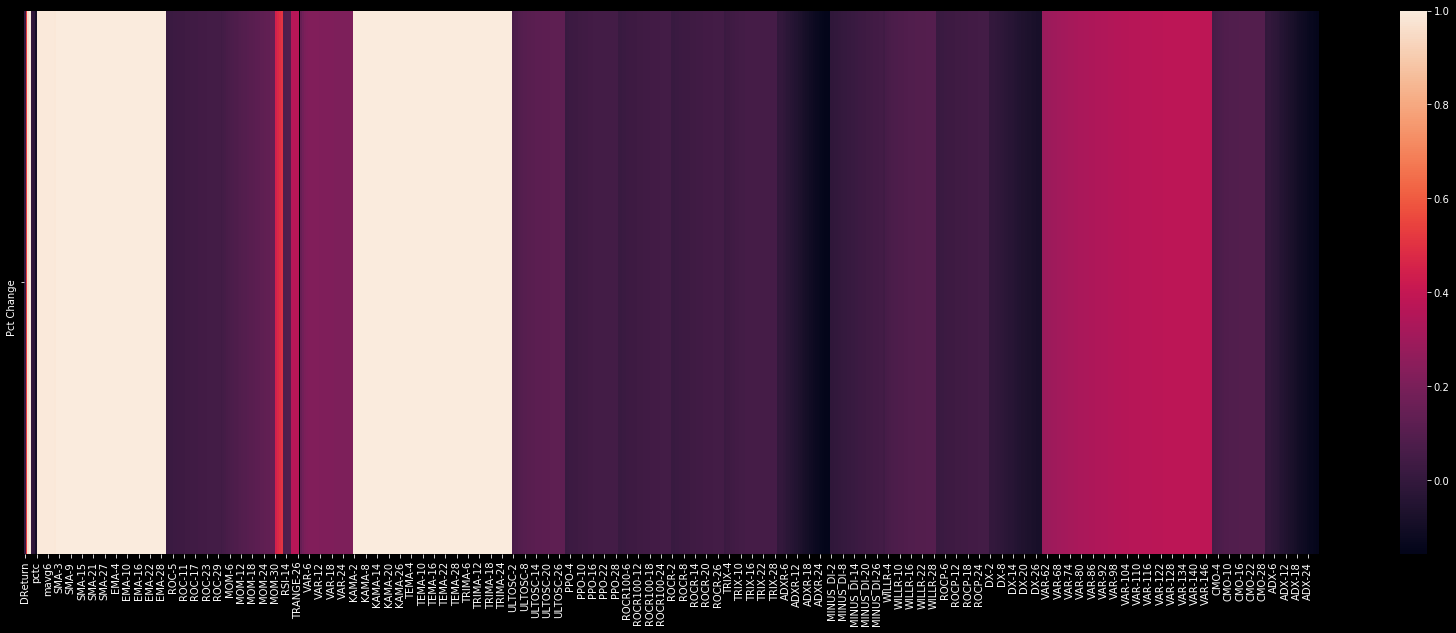

In [10]:
highest=0
for col in range(len(fdata.columns)):
    if fdata.reset_index(drop=True).iloc[:,col].first_valid_index()>highest:
        highest=fdata.iloc[:,col].reset_index(drop=True).first_valid_index()
corrd=fdata[highest:]
corco=pd.DataFrame(data=corrd).reset_index(drop=True)
corco.insert(0,'Pct Change',data['Close'][highest:][:].values)
plt.figure(figsize=(29,10))
corr=corco.corr().iloc[:1, 1:]
sns.heatmap(corr)
hf=[]
for col in corr.columns:
    if corr[col].loc['Pct Change']>0.6:
        if col!='Adj Close' and col!='Pct Change' and col!='DReturn'and col!='High' and col!='Close'and col!='Low':
            print(corr[col]['Pct Change'], col)
            hf.append(col)
#hf=hf[:]
hf

In [11]:
#scaler=MinMaxScaler(feature_range=(0,1))
#X=fdata[['ROC-2','ROC-3','ROCR-2','ROCR-3','ROCP-2','ROCP-3','MOM-2', 'ROCR100-2', 'Close']]#.dropna()
X=fdata[hf]
highest=-1
for col in range(len(X.columns)):
    if X.reset_index(drop=True).iloc[:,col].first_valid_index()>highest:
        highest=X.iloc[:,col].reset_index(drop=True).first_valid_index()
last=X[-1:]
X=X[highest:][:-1].dropna()
#X=fdata[['Close']][highest:].dropna()
y=data['Close'][highest:].shift(-1)#.dropna()
tpec=0.75
size=int(len(X)*tpec)
X_train= X[0:size]
X_test = X[size:]
y_train= y[0:size]
y_test= y[size:-1]
#y_train=y_train.astype('int')
#y_test=y_test.astype('int')

In [464]:
#param_grid=[{'max_depth': np.arange(1,20,1)}]

#model=RandomizedSearchCV(DecisionTreeClassifier(), param_grid)
model=DecisionTreeClassifier(max_depth=4)
model.fit(X_train,y_train)
pred=model.predict(X_test)

In [458]:
model=SVC(C=1, gamma=0.1)
model.fit(X_train,y_train)
pred=model.predict(X_test)

In [256]:
#model=LinearRegression()
#model=RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50, min_samples_split=50)
#model=knn(n_neighbors=5)
#model=mlp(solver='lbfgs',activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              #beta_2=0.999, early_stopping=False, epsilon=1e-08,
              #hidden_layer_sizes=(100,), learning_rate='constant',
              #learning_rate_init=0.001, max_fun=15000, max_iter=200,
              #momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              #power_t=0.5, random_state=100, shuffle=True,
              #tol=0.0001, validation_fraction=0.1, verbose=False,
              #warm_start=False)
# param_grid=[{'activation': ['identity', 'logistic', 'tanh','relu'],
                          #'max_iter': [100, 200, 300],
                          #'solver': ['lbfgs', 'sgd', 'adam']}],
             #pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             #scoring=None, verbose=0)
param_grid=[{'activation': ['identity', 'logistic', 'tanh', 'relu'],
                          'max_iter': [100,200,300],
                          'solver': ['lbfgs', 'sgd', 'adam']}]
                        

#for i in np.arange(1,21,1):
model=RandomizedSearchCV(MLPClassifier(), param_grid)
model.fit(X_train,y_train)
pred=model.predict(X_test)
print("run",accuracy_score(y_test, pred[:-1]))
model.best_params_

/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarni

run 0.3625461254612546


{'solver': 'sgd', 'max_iter': 200, 'activation': 'logistic'}

In [489]:
model=MLPClassifier(random_state=12,activation='relu',hidden_layer_sizes=(150,), max_iter=(200),solver='adam')
model.fit(X_train,y_train)
pred=model.predict(X_test)

/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
param_grid=[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                          'gamma': ['scale', 'auto'],
                          'C': np.arange(1, 10, 1)}]

model=RandomizedSearchCV(SVC(), param_grid)
model.fit(X_train,y_train)
pred=model.predict(X_test)

In [407]:
scaler=StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model=Sequential()

model.add(Dense(12, input_dim=len(X.columns), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train,y_train, epochs=10, batch_size=10)
pred=model.predict(X_test)
pred=pred.round()
accuracy_score(pred, y_test)

Epoch 1/10
326/326 [==============================] - 0s 1ms/step - loss: 0.3749 - accuracy: 0.3007
Epoch 2/10
326/326 [==============================] - 0s 1ms/step - loss: 0.1763 - accuracy: 0.2909
Epoch 3/10
326/326 [==============================] - 0s 1ms/step - loss: 0.1232 - accuracy: 0.2909
Epoch 4/10
326/326 [==============================] - 0s 1ms/step - loss: 0.0773 - accuracy: 0.2909
Epoch 5/10
326/326 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.2909
Epoch 6/10
326/326 [==============================] - 0s 1ms/step - loss: -0.0229 - accuracy: 0.2909
Epoch 7/10
326/326 [==============================] - 0s 1ms/step - loss: -0.0865 - accuracy: 0.2909
Epoch 8/10
326/326 [==============================] - 0s 1ms/step - loss: -0.1654 - accuracy: 0.2909
Epoch 9/10
326/326 [==============================] - 0s 1ms/step - loss: -0.2518 - accuracy: 0.2909
Epoch 10/10
326/326 [==============================] - 0s 1ms/step - loss: -0.3411 - accuracy: 0

0.3514760147601476

In [316]:
model=MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(80,), random_state=12)
model.fit(X_train,y_train)
pred=model.predict(X_test)

In [383]:
model=knn()
model.fit(X_train,y_train)
pred=model.predict(X_test)

In [508]:
model=RandomForestRegressor()
#model=RandomForestClassifier()
model.fit(X_train,y_train)
pred=model.predict(X_test)
pred=pd.DataFrame(data=pred, index=X_test.index)

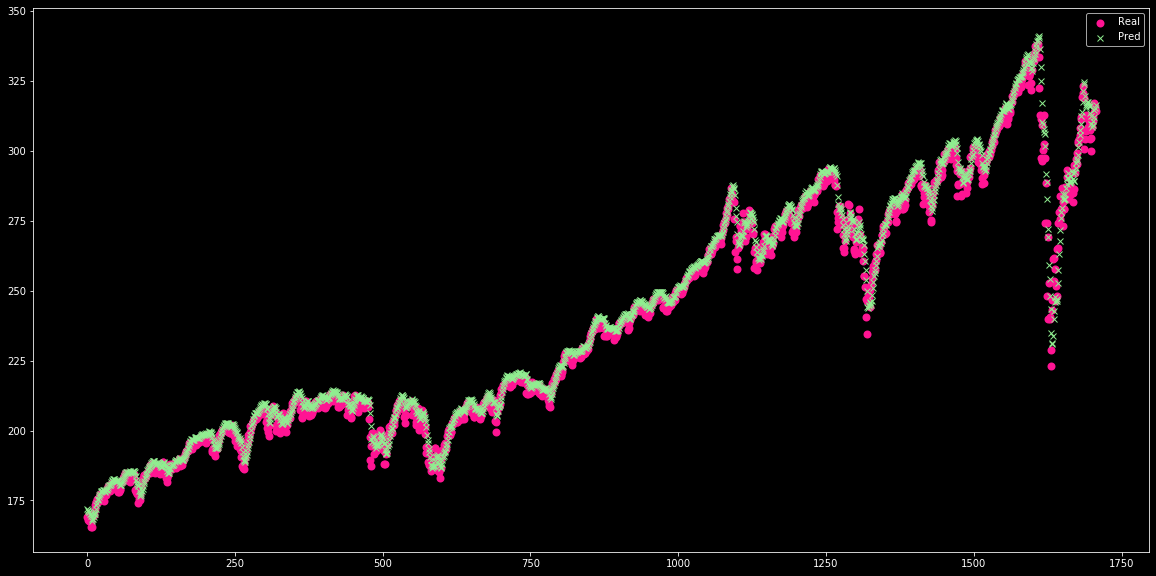

ValueError: continuous is not supported

In [772]:
# print("Percentage Error: ", round((mae(pred, y_test[:213])/data['Adj Close'][-1])*100, 3),"%")
#for i in range(0,len(pred.columns)):
    #plt.plot(np.array(pred.iloc[:,i].shift(27)),label=pred.iloc[:,i].name, linewidth=2)
plt.figure(figsize=(20,10))
plt.scatter(y=np.array(y_test),x=np.arange(len(y_test)), marker="o",label="Real", color="deeppink",linewidth=2)
plt.scatter(y=pred,x=np.arange(len(pred)),color="lightgreen", linewidth=1,label="Pred", marker="x")
plt.legend()
plt.show()
conf=confusion_matrix(y_test, pred, labels=[-1,0,1])
print(accuracy_score(y_test, pred))
#model.best_params_

In [745]:
model=LinearRegression()#solver='lbfgs')
model.fit(X_train,y_train)
pred=model.predict(X_test)
pred=pd.DataFrame(data=pred, index=X_test.index)

In [598]:
model=svm.SVR()
model.fit(X_train,y_train)
pred=model.predict(X_test)
pred=pd.DataFrame(data=pred, index=X_test.index)

In [742]:
from sklearn.neighbors import KNeighborsRegressor
model=KNeighborsRegressor()
model.fit(X_train,y_train)
pred=model.predict(X_test)
pred=pd.DataFrame(data=pred, index=X_test.index)

In [801]:
model=MLPRegressor(solver='lbfgs')
model.fit(X_train,y_train)
pred=model.predict(X_test)
pred=pd.DataFrame(data=pred, index=X_test.index)

/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Tomorrow's Prediction:  [[314.0174461]]


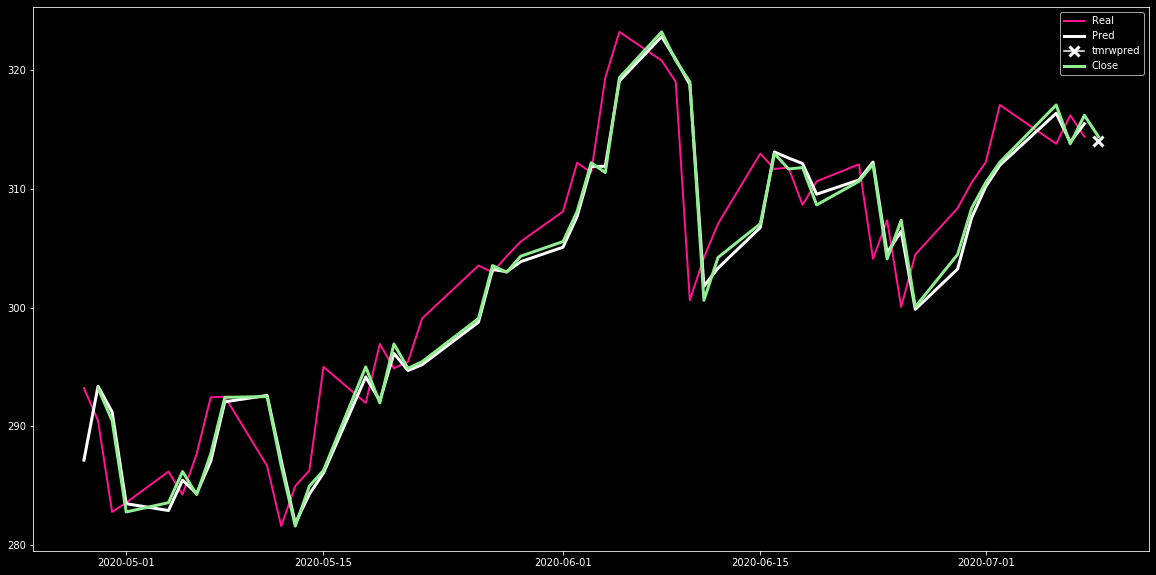

Error in Points:  1.619780344430998


In [802]:
# print("Percentage Error: ", round((mae(pred, y_test[:213])/data['Adj Close'][-1])*100, 3),"%")
#for i in range(0,len(pred.columns)):
    #plt.plot(np.array(pred.iloc[:,i].shift(27)),label=pred.iloc[:,i].name, linewidth=2)
plt.figure(figsize=(20,10))
plt.plot(y_test[-50:],label="Real", color="deeppink",linewidth=2)
plt.plot(pred[-50:],color="white", linewidth=3,label="Pred")
lastpred=model.predict(last)
lastpred=pd.DataFrame(data=lastpred,index=last.index)
print("Tomorrow's Prediction: ", lastpred.values)
plt.plot(lastpred,marker='x',label="tmrwpred", ms=10,mew=3, color="white")
plt.plot(data['Close'][highest:][-50:], lw=3,label="Close", color="lightgreen")
plt.legend()
plt.show()
print("Error in Points: ",mae(y_test, pred))
#model.best_params_

In [803]:
y_test, lastpred

(Date
 2013-09-26    168.910004
 2013-09-27    168.009995
 2013-09-30    169.339996
 2013-10-01    169.179993
 2013-10-02    167.619995
                  ...    
 2020-07-01    312.230011
 2020-07-02    317.049988
 2020-07-06    313.779999
 2020-07-07    316.179993
 2020-07-08    314.380005
 Name: Close, Length: 1707, dtype: float64,
                      0
 Date                  
 2020-07-09  314.017446)

In [495]:
realp=0
realp+=confm.iloc[:,0].iloc[1]
realp+=confm.iloc[:,0].iloc[2]
realp+=confm.iloc[:,2].iloc[0]
realp+=confm.iloc[:,2].iloc[1]xc

reals=1-(realp/(conf.sum()))
reals

0.6256643887623387

In [470]:
lastpred=model.predict(last)
pred=pd.DataFrame(data=pred,index=X_test.index)
print("Tomorrow's Prediction", lastpred)

Tomorrow's Prediction [-1]


In [766]:
pred, y_test

(                     0
 Date                  
 2013-09-26  169.738933
 2013-09-27  169.424866
 2013-09-30  168.666418
 2013-10-01  168.637147
 2013-10-02  168.758132
 ...                ...
 2020-07-01  305.592312
 2020-07-02  307.395368
 2020-07-06  310.522094
 2020-07-07  311.786474
 2020-07-08  312.698288
 
 [1707 rows x 1 columns],
 Date
 2013-09-26    168.910004
 2013-09-27    168.009995
 2013-09-30    169.339996
 2013-10-01    169.179993
 2013-10-02    167.619995
                  ...    
 2020-07-02    317.049988
 2020-07-06    313.779999
 2020-07-07    316.179993
 2020-07-08    314.380005
 2020-07-09           NaN
 Name: Close, Length: 1708, dtype: float64)

In [35]:
accuracy_score(y_test[:len(pred)][-10:],pred[-10:])

0.1

In [ ]:
#### y_test[:len(pred)]

In [302]:
spypred65=pd.DataFrame(data=pred,index=X_test.index)
spypred65

,0
Date,
2015-02-20,0
2015-02-23,0
2015-02-24,0
2015-02-25,0
2015-02-26,0
...,...
2020-06-29,1
2020-06-30,-1
2020-07-01,1


In [148]:
#Prediction SPY: tmrw, pct change >0.67 mayb
spypred

,0
Date,
2015-02-20,0
2015-02-23,0
2015-02-24,0
2015-02-25,0
2015-02-26,0
...,...
2020-06-29,1
2020-06-30,-1
2020-07-01,1


In [321]:
senspred=pd.DataFrame(data=pred,index=X_test.index)
senspred

,0
Date,
2015-02-12,0
2015-02-13,0
2015-02-16,1
2015-02-18,1
2015-02-19,0
...,...
2020-07-01,0
2020-07-02,0
2020-07-03,1


In [106]:
p=pd.DataFrame(pred, index=y_test.index[:len(pred)])
y_test=pd.DataFrame(y_test)

p.iloc[:-5], y_test.iloc[:5]

(            0
 Date         
 2015-02-17  0
 2015-02-18  0
 2015-02-19  0
 2015-02-20  0
 2015-02-23  0
 ...        ..
 2020-06-17  0
 2020-06-18 -1
 2020-06-19  1
 2020-06-22  0
 2020-06-23 -1
 
 [1348 rows x 1 columns],
             Movement
 Date                
 2015-02-17         0
 2015-02-18         0
 2015-02-19         0
 2015-02-20         0
 2015-02-23         0)

In [1152]:
corr=corco.corr()
corr

,Pct Change,Adj Close,DReturn,Vol,High,Close,Vol Diff 16,ROC-2,ROC-3,ROC-4,...,CCI-20,CCI-21,CCI-22,CCI-23,CCI-24,CCI-25,CCI-26,CCI-27,CCI-28,CCI-29
Pct Change,1.000000,0.026711,0.536301,NaN,0.030274,0.042817,NaN,0.648414,0.539199,0.486305,...,0.334652,0.330962,0.326871,0.322756,0.315432,0.311824,0.308961,0.306344,0.302255,0.299641
Adj Close,0.026711,1.000000,0.018642,NaN,0.995235,0.995295,NaN,0.039681,0.050862,0.060265,...,0.140509,0.141593,0.142049,0.142717,0.143528,0.144562,0.145497,0.146708,0.148386,0.150290
DReturn,0.536301,0.018642,1.000000,NaN,-0.003153,0.018167,NaN,0.417717,0.329980,0.299885,...,0.170256,0.168048,0.165204,0.162160,0.159065,0.156638,0.154498,0.152605,0.150047,0.148351
Vol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High,0.030274,0.995235,-0.003153,NaN,1.000000,0.999238,NaN,0.044260,0.054605,0.063047,...,0.136839,0.138067,0.138677,0.139471,0.140115,0.141182,0.142160,0.143413,0.144962,0.146835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCI-25,0.311824,0.144562,0.156638,NaN,0.141182,0.144015,NaN,0.456444,0.557092,0.623570,...,0.976181,0.984305,0.990847,0.995701,0.998865,1.000000,0.998908,0.996220,0.992391,0.987708
CCI-26,0.308961,0.145497,0.154498,NaN,0.142160,0.145009,NaN,0.451086,0.550676,0.617159,...,0.969090,0.977971,0.985441,0.991455,0.995995,0.998908,1.000000,0.998992,0.996456,0.992783
CCI-27,0.306344,0.146708,0.152605,NaN,0.143413,0.146275,NaN,0.446179,0.544673,0.610904,...,0.961759,0.971243,0.979461,0.986362,0.991959,0.996220,0.998992,1.000000,0.999052,0.996615
CCI-28,0.302255,0.148386,0.150047,NaN,0.144962,0.147828,NaN,0.440150,0.537834,0.604058,...,0.954246,0.964221,0.973046,0.980666,0.987086,0.992391,0.996456,0.999052,1.000000,0.999052


In [585]:
scores={}

for i in np.arange(0.01,1,0.01):
    corco=pd.DataFrame(data=fdata).reset_index()
    corco.insert(1,'Adj Close',data['Adj Close'].shift(-1).values)
    corco.insert(0,'Pct Change',data['Pct Change'].values)
    corr=corco.corr().iloc[:1]
    hf=[]
    for col in corr.columns:
        if corr[col]['Pct Change']>0.57:
            if col!='Pct Change' and col!='DReturn':
                hf.append(col)
    scaler=MinMaxScaler(feature_range=(0,1))
    #X=fdata[['ROC-2','ROC-3','ROCR-2','ROCR-3','ROCP-2','ROCP-3','MOM-2', 'ROCR100-2','CCI-2']].dropna()
    X=fdata[hf].dropna()
    y=data['Movement'].iloc[:len(X)+1].shift(-1).dropna()

    tpec=0.75
    size=int(len(X)*tpec)
    X_train, X_test, y_train, y_test = X[0:size], X[size:len(X)], y[0:size], y[size:len(y)]
    y_train=y_train.astype('int')
    y_test=y_test.astype('int')
    #model=LinearRegression()
    model=RandomForestClassifier(n_estimators=500)
    #model=knn(n_neighbors=5)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    sc=accuracy_score(y_test[:len(y_test)], pred)
    scores.update({f"P{i}":sc})

KeyboardInterrupt: 

In [557]:
X_train, y_train

(               ROC-2   ROCR100-2    ROCR-2    ROCP-2
 Date                                                
 2003-05-27  4.644275  104.644275  1.046443  0.046443
 2003-05-28  4.029303  104.029303  1.040293  0.040293
 2003-05-29  0.565825  100.565825  1.005658  0.005658
 2003-05-30  1.294019  101.294019  1.012940  0.012940
 2003-06-02  1.890109  101.890109  1.018901  0.018901
 ...              ...         ...       ...       ...
 2016-03-18  2.747584  102.747584  1.027476  0.027476
 2016-03-21  0.738552  100.738552  1.007386  0.007386
 2016-03-22 -0.029381   99.970619  0.999706 -0.000294
 2016-03-23 -1.935484   98.064516  0.980645 -0.019355
 2016-03-24 -1.940035   98.059965  0.980600 -0.019400
 
 [3231 rows x 4 columns],
 Date
 2003-05-27    0
 2003-05-28    0
 2003-05-29    1
 2003-05-30    1
 2003-06-02   -1
              ..
 2016-03-18    0
 2016-03-21    0
 2016-03-22   -1
 2016-03-23    0
 2016-03-24    0
 Name: Movement, Length: 3231, dtype: int64)

In [9]:
scrs={}

for i in np.arange(0,21,1):
    print("Run",i)
    model=mlp(random_state=i)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    sc=accuracy_score(y_test[:len(pred)], pred)
    scrs.update({f"P{i}":sc})

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20


In [1339]:
highest=0
for i in scores.values():
    if i>highest:
        highest=i
    
for key, value in scores.items(): 
         if highest==value: 
            print(key, value)

Percentage: 0.75 0.9690098261526833


([<matplotlib.axis.XTick at 0x1a588efdd0>,
 <a list of 84 Text xticklabel objects>)

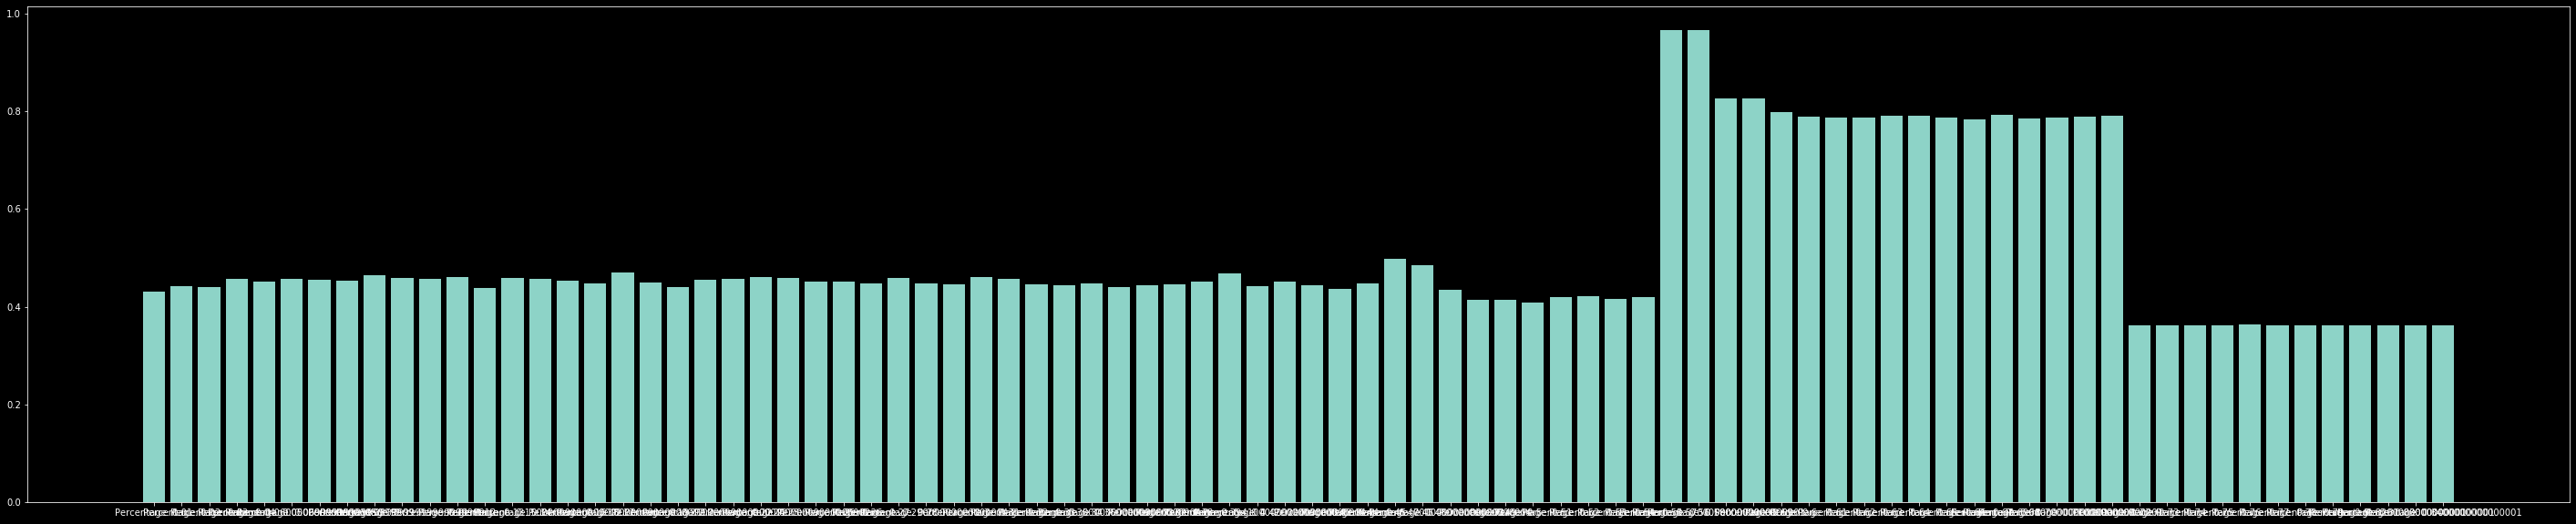

In [1327]:
plt.figure(figsize=(50,10))
plt.bar(range(1,len(scores)+1),list(scores.values()))
plt.xticks(range(1,len(scores)+1),list(scores.keys()))

In [1313]:
scr=[]
for i in scores.values():
    print(i)
    scr.append(pd.Series(i))

0.4592933947772657
0.4362108479755539
0.45261561789234267
0.4682299546142209
0.4167927382753404
0.8027210884353742
0.7928949357520786
0.36205593348450493


/Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [1504]:
sco=sorted(sco.items)
sco

AttributeError: 'list' object has no attribute 'items'

In [262]:
data['Adj Close']

Date
1998-12-31     83.011604
1999-01-04     82.822250
1999-01-05     83.768890
1999-01-06     85.788452
1999-01-07     85.367714
                 ...    
2020-06-29    304.459991
2020-06-30    308.359985
2020-07-01    310.519989
2020-07-02    312.230011
2020-07-06    317.049988
Name: Adj Close, Length: 5412, dtype: float64

In [430]:
#model=DecisionTreeRegressor(criterion='mse') 
#model=LinearRegression()
#model=RandomForestRegressor()
#model=XGBRegressor(n_estimators=500, learning_rate=0.1)
model=Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,batch_size=10)
pred=pd.DataFrame()
sco={}
for i in range(20,30+1):
    for k in range(20,30+1):
        for l in range(20,30+1):
            model=RandomForestClassifier(n_estimators=100,max_leaf_nodes=i, max_depth=k, min_samples_split=l,n_jobs=-1)
            model.fit(X_train,y_train)
            pred[f'p{i}-{k}-{l}']=model.predict(X_test)
            sco.update({f'p{i}-{k}-{l}':accuracy_score(pred[f'p{i}-{k}-{l}'], y_test.iloc[:len(pred[f'p{i}-{k}-{l}'])])})

Epoch 1/5


ValueError: in user code:

    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1595 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4692 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /Users/advikchaudhary/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:172 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 10) vs (None, 1))
